Fitting 5 folds for each of 64 candidates, totalling 320 fits
Mejores parámetros encontrados:
{'knn__leaf_size': 20, 'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Mejor score CV (accuracy): 0.9920


,rank_test_score,mean_test_score,std_test_score,params,mean_train_score
53,1,0.992,0.016,"{'knn__leaf_size': 30, 'knn__metric': 'manhatt...",1.000000
20,1,0.992,0.016,"{'knn__leaf_size': 20, 'knn__metric': 'manhatt...",0.983859
21,1,0.992,0.016,"{'knn__leaf_size': 20, 'knn__metric': 'manhatt...",1.000000
52,1,0.992,0.016,"{'knn__leaf_size': 30, 'knn__metric': 'manhatt...",0.983859
22,5,0.976,0.032,"{'knn__leaf_size': 20, 'knn__metric': 'manhatt...",0.979838
23,5,0.976,0.032,"{'knn__leaf_size': 20, 'knn__metric': 'manhatt...",1.000000
24,5,0.976,0.032,"{'knn__leaf_size': 20, 'knn__metric': 'manhatt...",0.977818
50,5,0.976,0.048,"{'knn__leaf_size': 30, 'knn__metric': 'manhatt...",0.981838
51,5,0.976,0.048,"{'knn__leaf_size': 30, 'knn__metric': 'manhatt...",1.000000
19,5,0.976,0.048,"{'knn__leaf_size': 20, 'knn__metric': 'manhatt...",1.000000



Accuracy sobre test_holdout: 0.9815


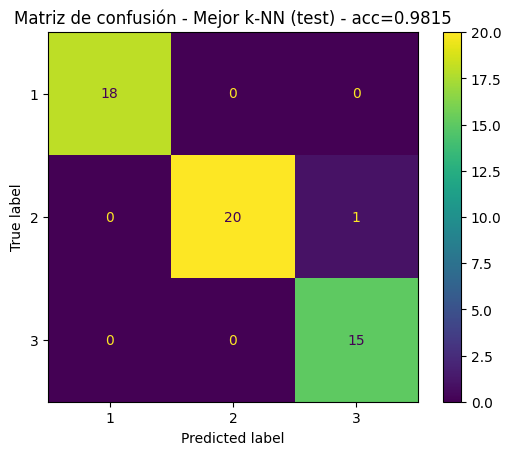

In [1]:
# -*- coding: utf-8 -*-
# Notebook: Actividad 2.19 - GridSearchCV para k-NN sobre Wine (UCI)

# 0) Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
RND = 42

# 1) Cargar dataset (igual que en 2.16)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
cols = [
    "Class", "Alcohol", "Malic_acid", "Ash", "Alcalinity_of_ash", "Magnesium",
    "Total_phenols", "Flavanoids", "Nonflavanoid_phenols", "Proanthocyanins",
    "Color_intensity", "Hue", "OD280_OD315", "Proline"
]
df = pd.read_csv(url, header=None, names=cols)

# 2) Preparar X, y y split de test final
predictor_cols = df.columns.drop("Class")
X = df[predictor_cols].values
y = df["Class"].values

# Separamos un test_holdout para evaluar el mejor modelo al final
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RND
)

# 3) Pipeline: StandardScaler + KNeighborsClassifier
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# 4) Grid (opciones: rápido vs exhaustivo)
# Opción RÁPIDA
param_grid_quick = {
    "knn__n_neighbors": list(range(1, 16, 2)),   # 1,3,5,...,15
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"],   # métricas comunes
    "knn__leaf_size": [20, 30]                   # pequeño ajuste
}

# Opción EXHAUSTIVA
param_grid_full = {
    "knn__n_neighbors": list(range(1, 31)),      # 1..30
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski", "euclidean", "manhattan"],
    "knn__p": [1, 2],
    "knn__leaf_size": [15, 30, 50]
}

# Eligir el grid:
param_grid = param_grid_quick   # cambia a param_grid_full si quieres mayor búsqueda

# 5) Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

# 6) GridSearchCV
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# 7) Ejecutar búsqueda (sobre train+val)
gs.fit(X_trainval, y_trainval)

# 8) Resultados: mejor combinación y CV score
print("Mejores parámetros encontrados:")
print(gs.best_params_)
print(f"Mejor score CV (accuracy): {gs.best_score_:.4f}")

# 9) Tabla resumen
results_df = pd.DataFrame(gs.cv_results_)
# ordenamos por rank y mostramos las columnas más útiles
cols_show = ["rank_test_score", "mean_test_score", "std_test_score", "params", "mean_train_score"]
display(results_df.sort_values("rank_test_score").loc[:, cols_show].head(10))

# 10) Evaluación final sobre el test_holdout
best_model = gs.best_estimator_
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nAccuracy sobre test_holdout: {test_acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot()
plt.title(f"Matriz de confusión - Mejor k-NN (test) - acc={test_acc:.4f}")
plt.show()

# 11) Visualizar la evolución de mean_test_score vs n_neighbors
if "knn__n_neighbors" in results_df.columns:
    # extraemos n_neighbors de params y agrupamos por él
    results_df["n_neighbors"] = results_df["params"].apply(lambda p: p.get("knn__n_neighbors", np.nan))
    pivot = results_df.groupby("n_neighbors").mean().reset_index()
    plt.figure(figsize=(8,4))
    plt.plot(pivot["n_neighbors"], pivot["mean_test_score"], marker='o')
    plt.xticks(pivot["n_neighbors"])
    plt.xlabel("n_neighbors")
    plt.ylabel("Mean CV accuracy")
    plt.title("Evolución de mean_test_score según n_neighbors (promedio sobre configuraciones)")
    plt.grid(True)
    plt.show()
